# Electrical Symbol Detection - Inference
Run predictions on floor plans using the trained FasterRCNN model

## 0. Environment Setup

In [23]:
import sys
import os

# Mount Google Drive (for checkpoints and dataset)
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        print("✓ Google Drive mounted at /content/drive")
        DRIVE_MOUNTED = True
    except Exception as e:
        print(f"⚠ Could not mount Google Drive: {e}")
        DRIVE_MOUNTED = False
else:
    print("⚠ Running locally (not on Google Colab)")
    DRIVE_MOUNTED = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted at /content/drive


In [24]:
import subprocess
import os

# Clone or update repository
repo_path = '/content/symbol-detection'

if not os.path.exists(repo_path):
    print("Cloning repository...")
    subprocess.run(['git', 'clone', 'https://github.com/BhanukaDev/symbol-detection.git', repo_path], check=True)
    print(f"✓ Repository cloned to {repo_path}")
else:
    print("Repository already exists, pulling latest changes...")
    os.chdir(repo_path)
    subprocess.run(['git', 'pull'], check=True)
    print("✓ Repository updated")

os.chdir('/content/symbol-detection/python')
print(f"✓ Working directory: {os.getcwd()}")

Repository already exists, pulling latest changes...
✓ Repository updated
✓ Working directory: /content/symbol-detection/python


In [25]:
import importlib
import os
import sys

# First ensure dependencies are installed
print("Installing dependencies...")
!pip install -q torch torchvision pycocotools timm torchmetrics

# Install/update the package (skip dependencies since they're installed)
print("\nInstalling symbol-detection package...")
!pip install --no-deps --force-reinstall -q -e /content/symbol-detection/python/

# Force reload everything
print("\nReloading modules...")
if 'symbol_detection' in sys.modules:
    del sys.modules['symbol_detection']
if 'symbol_detection.inference' in sys.modules:
    del sys.modules['symbol_detection.inference']
if 'symbol_detection.inference.predictor' in sys.modules:
    del sys.modules['symbol_detection.inference.predictor']

# Import fresh
from symbol_detection.inference.predictor import SymbolDetectionPredictor

print("✓ Package installed and reloaded")
print("✓ SymbolDetectionPredictor ready")
print("✓ Module version with fixed predict method")

Installing dependencies...

Installing symbol-detection package...
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for symbol-detection (pyproject.toml) ... done

Reloading modules...
✓ Package installed and reloaded
✓ SymbolDetectionPredictor ready
✓ Module version with fixed predict method


## 1. Setup and Imports

In [51]:
import sys
import glob
import re
from pathlib import Path

# Setup paths
sys.path.insert(0, '/content/symbol-detection/python/src')

# Define checkpoint and dataset directories
if 'google.colab' in sys.modules:
    # Colab environment
    checkpoint_dir = '/content/drive/MyDrive/symbol-detection/checkpoints'
    dataset_dir = '/content/drive/MyDrive/symbol-detection/dataset'
    categories_file = '/content/drive/MyDrive/symbol-detection/dataset/annotations.json'
    os.chdir('/content/symbol-detection/python')
else:
    # Local environment
    checkpoint_dir = str(Path.cwd().parent.parent / 'checkpoints')
    dataset_dir = str(Path.cwd().parent.parent / 'dataset')
    categories_file = str(Path.cwd().parent.parent / 'dataset' / 'annotations.json')

# Helper function to extract epoch number from filename
def get_epoch_num(filepath):
    match = re.search(r'model_epoch_(\d+).pth', filepath)
    return int(match.group(1)) if match else -1

# Find all checkpoints
checkpoints = glob.glob(str(Path(checkpoint_dir) / 'model_epoch_*.pth'))

if checkpoints:
    # Sort numerically by epoch number (Highest epoch last)
    checkpoints = sorted(checkpoints, key=get_epoch_num)
    checkpoint_path = Path(checkpoints[-1])
    print(f"✓ Found {len(checkpoints)} checkpoints")
    print(f"✓ Selected latest model: {checkpoint_path.name} (Epoch {get_epoch_num(str(checkpoint_path))})")
else:
    raise FileNotFoundError(f"No checkpoints found in {checkpoint_dir}")

print(f"✓ Paths configured")
print(f"✓ Dataset: {dataset_dir}")
print(f"✓ Categories: {categories_file}")

✓ Found 13 checkpoints
✓ Selected latest model: model_epoch_120.pth (Epoch 120)
✓ Paths configured
✓ Dataset: /content/drive/MyDrive/symbol-detection/dataset
✓ Categories: /content/drive/MyDrive/symbol-detection/dataset/annotations.json


In [46]:
# Import libraries
import cv2
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from symbol_detection.inference import SymbolDetectionPredictor

print("✓ All imports loaded")

✓ All imports loaded


## 2. Load Trained Model

In [52]:
# Load the model
print("Loading model from checkpoint...")
print(f"Checkpoint path: {checkpoint_path}")
print(f"Checkpoint exists: {checkpoint_path.exists()}")
print(f"Checkpoint size: {checkpoint_path.stat().st_size / 1e6:.1f} MB")

# Create predictor with the loaded SymbolDetectionPredictor
# Note: num_classes=8 includes background class (7 symbols + 1 background)
try:
    predictor = SymbolDetectionPredictor(
        checkpoint_path=str(checkpoint_path),
        num_classes=8,  # 7 symbols + 1 background
        categories_file=str(categories_file),  # Load actual symbol names from COCO JSON
        device='cuda' if torch.cuda.is_available() else 'cpu',
        confidence_threshold=0.5
    )
    print("✓ Model loaded successfully!")
    print(f"✓ Classes: {list(predictor.categories.values())}")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    import traceback
    traceback.print_exc()
    raise

Loading model from checkpoint...
Checkpoint path: /content/drive/MyDrive/symbol-detection/checkpoints/model_epoch_120.pth
Checkpoint exists: True
Checkpoint size: 330.3 MB
Loading model from /content/drive/MyDrive/symbol-detection/checkpoints/model_epoch_120.pth...
✓ Model loaded on cuda
✓ Confidence threshold: 0.5
✓ Model loaded successfully!
✓ Classes: ['Light', 'Two-pole, one-way switch', 'Duplex Receptacle', 'Single-pole, one-way switch', 'Three-pole, one-way switch', 'Junction Box', 'Two-way switch']


## 3. Inference on Test Images

In [53]:
# Get test images from dataset
images_dir = Path(dataset_dir) / 'images'
test_images = sorted(list(images_dir.glob('*.png')))[:5]  # Use first 5 images

print(f"Found {len(test_images)} test images")
print(f"Processing {len(test_images)} samples...\n")

# Run inference
results = []
for img_path in test_images:
    image = cv2.imread(str(img_path))
    if image is None:
        continue
    
    # Run prediction
    detections = predictor.predict(image, conf_threshold=0.50)
    
    result = {
        'image': img_path.name,
        'num_detections': len(detections),
        'detections': detections,
        'image_shape': image.shape,
    }
    results.append(result)
    
    print(f"{img_path.name}: {len(detections)} symbols detected")

print(f"\n✓ Inference complete")

Found 5 test images
Processing 5 samples...

floor_plan_0000.png: 16 symbols detected
floor_plan_0001.png: 11 symbols detected
floor_plan_0002.png: 12 symbols detected
floor_plan_0003.png: 10 symbols detected
floor_plan_0004.png: 18 symbols detected

✓ Inference complete


## 4. Visualize Detections

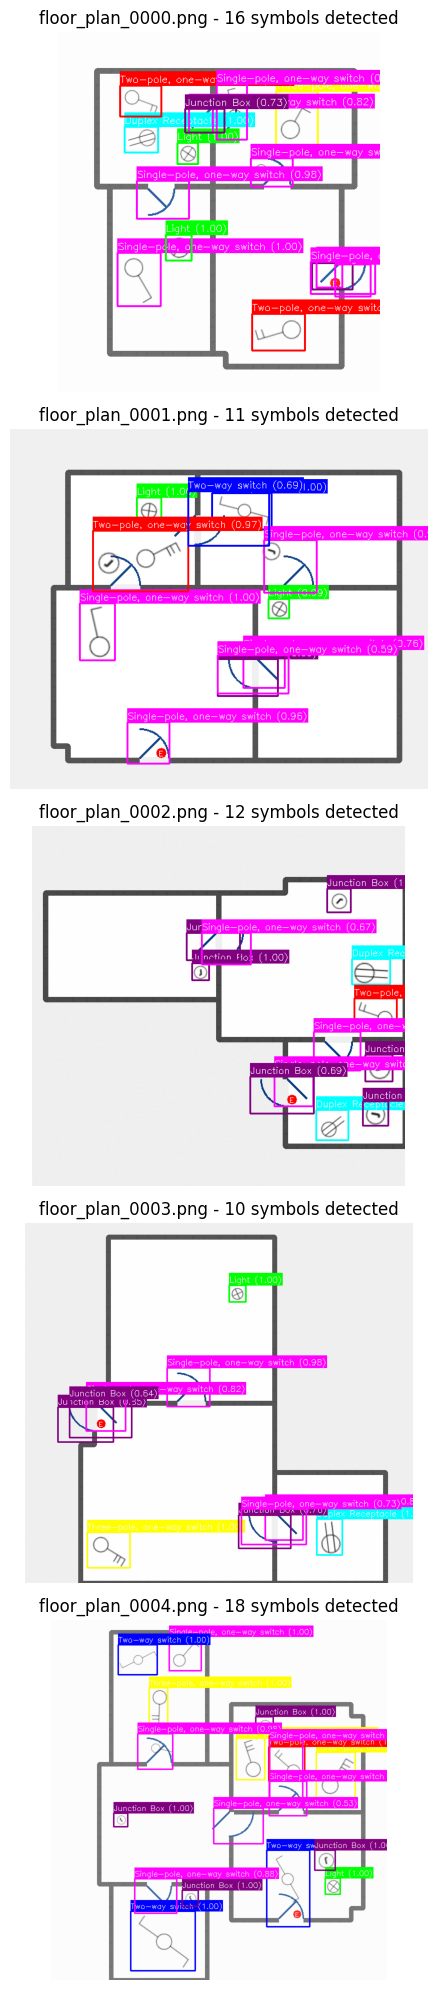

✓ Visualization complete


In [54]:
# Visualize detections with matplotlib
fig, axes = plt.subplots(len(test_images), 1, figsize=(12, 4 * len(test_images)))
if len(test_images) == 1:
    axes = [axes]

for idx, (img_path, result) in enumerate(zip(test_images, results)):
    image = cv2.imread(str(img_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create annotated image
    annotated = predictor.visualize(image, result['detections'])
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    
    # Display
    axes[idx].imshow(annotated_rgb)
    axes[idx].set_title(f"{img_path.name} - {result['num_detections']} symbols detected")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## 5. Detailed Detection Results

In [31]:
# Show detailed results for first image
print("Detection Details for First Image:\n")
print(f"Image: {results[0]['image']}")
print(f"Total Detections: {results[0]['num_detections']}\n")

for i, det in enumerate(results[0]['detections'], 1):
    print(f"{i}. {det['class_name']}")
    print(f"   Confidence: {det['confidence']:.3f}")
    print(f"   Box: ({det['bbox'][0]:.0f}, {det['bbox'][1]:.0f}) -> ({det['bbox'][2]:.0f}, {det['bbox'][3]:.0f})")
    print(f"   Size: {det['width']:.0f} x {det['height']:.0f}")
    print()

# Statistics
print("\nInference Statistics:")
total_detections = sum(r['num_detections'] for r in results)
avg_detections = total_detections / len(results) if results else 0
print(f"  Total images: {len(results)}")
print(f"  Total detections: {total_detections}")
print(f"  Average detections per image: {avg_detections:.1f}")

# Detection breakdown by class
class_counts = {}
for result in results:
    for det in result['detections']:
        class_name = det['class_name']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

print("\n  Detections by Class:")
for class_name, count in sorted(class_counts.items()):
    print(f"    {class_name}: {count}")

Detection Details for First Image:

Image: floor_plan_0000.png
Total Detections: 12

1. Light
   Confidence: 1.000
   Box: (432, 232) -> (476, 276)
   Size: 44 x 45

2. Two-pole, one-way switch
   Confidence: 0.999
   Box: (242, 412) -> (322, 529)
   Size: 80 x 117

3. Two-pole, one-way switch
   Confidence: 0.998
   Box: (520, 480) -> (620, 578)
   Size: 100 x 98

4. Duplex Receptacle
   Confidence: 0.996
   Box: (437, 579) -> (465, 608)
   Size: 28 x 30

5. Single-pole, one-way switch
   Confidence: 0.988
   Box: (533, 396) -> (602, 443)
   Size: 68 x 48

6. Single-pole, one-way switch
   Confidence: 0.982
   Box: (477, 566) -> (552, 636)
   Size: 75 x 70

7. Light
   Confidence: 0.975
   Box: (99, 117) -> (128, 146)
   Size: 30 x 29

8. Two-way switch
   Confidence: 0.927
   Box: (476, 278) -> (562, 393)
   Size: 86 x 114

9. Single-pole, one-way switch
   Confidence: 0.920
   Box: (337, 105) -> (395, 157)
   Size: 59 x 52

10. Single-pole, one-way switch
   Confidence: 0.904
   Box

## 6. Inference Performance Benchmarking

Benchmarking inference performance...

Inference Speed (10 runs):
  Average: 28.04 ms
  Std Dev: 2.74 ms
  Min: 26.00 ms
  Max: 35.46 ms
  Throughput: 35.7 images/sec

GPU Memory:
  Allocated: 169.7 MB
  Reserved: 802.0 MB
  Device: NVIDIA A100-SXM4-80GB


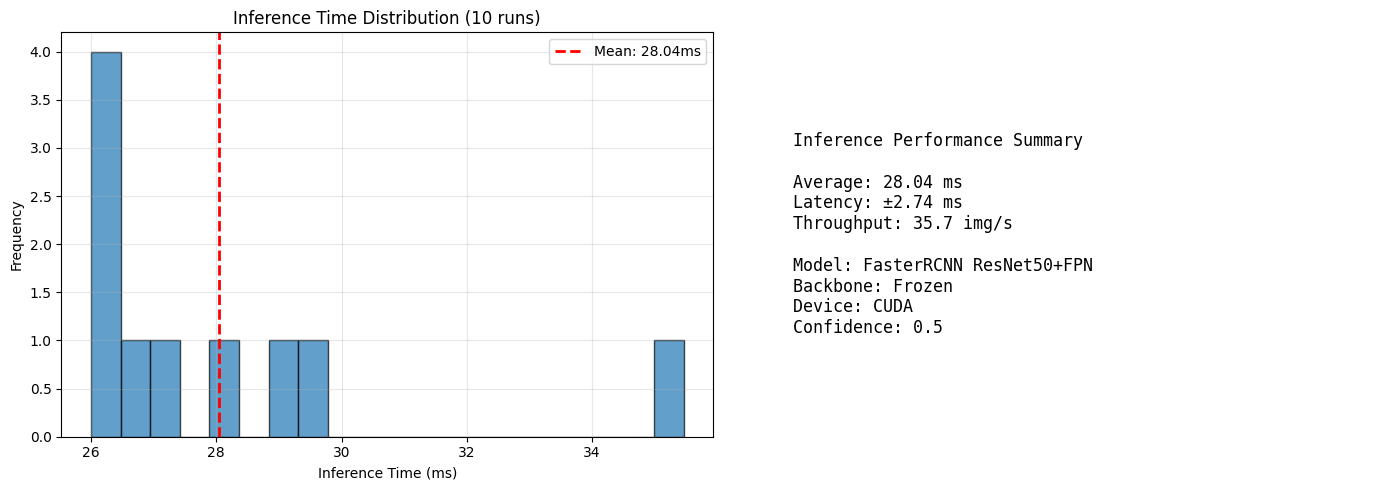


✓ Benchmark complete


In [32]:
import time
import torch

# Benchmark inference speed
print("Benchmarking inference performance...\n")

test_image = cv2.imread(str(test_images[0]))
num_runs = 10

times = []
for i in range(num_runs):
    start = time.time()
    _ = predictor.predict(test_image)
    elapsed = time.time() - start
    times.append(elapsed * 1000)  # Convert to ms

avg_time = np.mean(times)
std_time = np.std(times)
min_time = np.min(times)
max_time = np.max(times)

print(f"Inference Speed ({num_runs} runs):")
print(f"  Average: {avg_time:.2f} ms")
print(f"  Std Dev: {std_time:.2f} ms")
print(f"  Min: {min_time:.2f} ms")
print(f"  Max: {max_time:.2f} ms")
print(f"  Throughput: {1000/avg_time:.1f} images/sec")

# GPU Memory
if torch.cuda.is_available():
    print(f"\nGPU Memory:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"  Reserved: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")
    
    device_name = torch.cuda.get_device_name(0)
    print(f"  Device: {device_name}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of inference times
ax1.hist(times, bins=20, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Inference Time (ms)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Inference Time Distribution ({num_runs} runs)')
ax1.axvline(avg_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_time:.2f}ms')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Performance summary
summary_text = f"""
Inference Performance Summary

Average: {avg_time:.2f} ms
Latency: ±{std_time:.2f} ms
Throughput: {1000/avg_time:.1f} img/s

Model: FasterRCNN ResNet50+FPN
Backbone: Frozen
Device: {predictor.device.upper()}
Confidence: {predictor.confidence_threshold}
"""

ax2.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
         transform=ax2.transAxes, verticalalignment='center')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Benchmark complete")